# NEQR QAE
This notebook contains code for the NEQR-QAE Model.\
Inspired by [Romero et al](https://arxiv.org/pdf/1612.02806.pdf) and [Sim et al](https://arxiv.org/pdf/1810.10576.pdf).\
Developed by Filip Igic for his FYP.

In [5]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi
import matplotlib.pyplot as mpl

In [59]:
def neqr():
    qc = QuantumCircuit(3, name='NEQR')
    qc.h(0)
    qc.h(1)
    qc.x(0)
    qc.x(1)
    qc.ccx(0, 1, 2)
    qc.x(0)
    qc.x(1)
    return qc

def encode(x):
    qc = QuantumCircuit(3, name="Encode")
    qc.ry(x[0], 0)
    qc.cx(0, 1)
    qc.ry(x[1], 1)
    qc.cx(0,2)
    return qc

In [66]:
def f(x):
    qc = QuantumCircuit(3)

    qc.append(neqr(), qc.qubits[:3])

    qc.append(encode(x), qc.qubits[:3])

    qc.reset(1)
    qc.reset(2)

    qc.append(encode(x).inverse(), qc.qubits[:3])

    qc.append(neqr().inverse(), qc.qubits[:3])

    qc.measure_all()
    
    qasm_sim = Aer.get_backend('qasm_simulator')
    t_qc = transpile(qc, qasm_sim)
    qobj = assemble(t_qc, shots=4096)
    result = qasm_sim.run(qobj).result()
    counts = result.get_counts(qc)
    
    if '000' in counts:
        loss = counts['000']/4096
    else:
        loss = 0
    loss *= -1
    history.append(loss)
    return loss

Optimal parameters: [3.14159265 3.14159265], Loss: 0.0


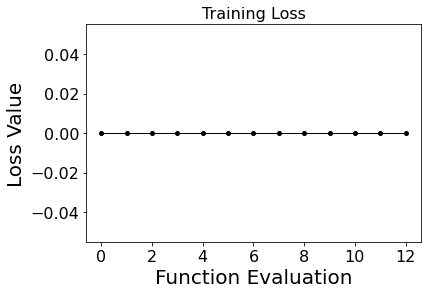

In [70]:
import scipy.optimize as sp

history=[] #history of losses through training

result = sp.minimize(f, [pi, pi], method='COBYLA', constraints={'type': 'ineq', 'fun': lambda x: 2. * pi - x})

op=result.x #optimal parameters
print(f'Optimal parameters: {op}, Loss: {result.fun}')

fig = mpl.figure(figsize=(6, 4))
mpl.plot(history, 'ko-', markersize=4, linewidth=1)
mpl.title("Training Loss", fontsize=16)
mpl.xlabel("Function Evaluation",fontsize=20)
mpl.ylabel("Loss Value", fontsize=20)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.show()

## Testing
Based on the optimal parameters found above, I will test them to see the quality of the image.

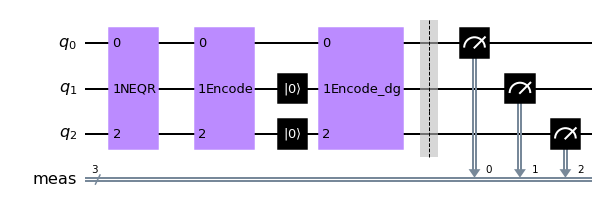

In [62]:
qc = QuantumCircuit(3)

qc.append(neqr(), qc.qubits[:3])

qc.append(encode(op), qc.qubits[:3])

qc.reset(1)
qc.reset(2)

qc.append(encode(op).inverse(), qc.qubits[:3])

qc.measure_all()

qc.draw('mpl')

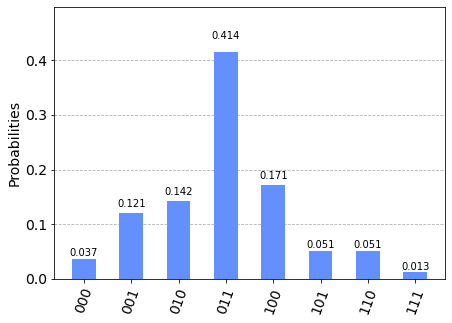

In [63]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc, shots=4096)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
plot_histogram(counts)

## Image Retrieval

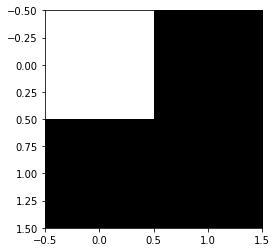

In [65]:
image=[[0, 0], [0, 0]]
values=[[0, 0], [0, 0]]
for x in counts:
    if x[-2:] == '00':
        if counts[x] > values[0][0]:
            values[0][0]=counts[x]
            image[0][0]=int(x[0:-2], 2)
    elif x[-2:] == '01':
        if counts[x] > values[0][1]:
            values[0][1]=counts[x]
            image[0][1]=int(x[0:-2], 2)
    elif x[-2:] == '10':
        if counts[x] > values[1][0]:
            values[1][0]=counts[x]
            image[1][0]=int(x[0:-2], 2)
    elif x[-2:] == '11':
        if counts[x] > values[1][1]:
            values[1][1]=counts[x]
            image[1][1]=int(x[0:-2], 2)
mpl.imshow(image, cmap="gray")

## NEQR with a higher range of pixel intensity

In [147]:
def neqr():
    qc = QuantumCircuit(4, name='NEQR')
    qc.h(0)
    qc.h(1)
    qc.x(1)

    qc.ccx(0, 1, 2)
    qc.ccx(0, 1, 3)

    qc.x(1)
    qc.x(0)
    qc.ccx(0, 1, 2)

    qc.x(0)
    qc.ccx(0, 1, 3)
    return qc

def encode(x):
    qc = QuantumCircuit(4, name="Encode")
    qc.ry(x[0], 0)
    qc.ry(x[1], 1)
    qc.ry(x[2], 2)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(1, 3)
    return qc

In [155]:
def f(x):
    qc = QuantumCircuit(4)

    qc.append(neqr(), qc.qubits[:4])

    qc.append(encode(x), qc.qubits[:4])

    qc.reset(1)
    qc.reset(2)
    qc.reset(3)

    qc.append(encode(x).inverse(), qc.qubits[:4])

    qc.append(neqr().inverse(), qc.qubits[:4])

    qc.measure_all()
    
    qasm_sim = Aer.get_backend('qasm_simulator')
    t_qc = transpile(qc, qasm_sim)
    qobj = assemble(t_qc, shots=4096)
    result = qasm_sim.run(qobj).result()
    counts = result.get_counts(qc)
    
    if '0000' in counts:
        loss = counts['0000']/4096
    else:
        loss = 0
    loss *= -1
    history.append(loss)
    return loss

Optimal parameters: [4.67744036 1.36099538 1.55608862], Loss: -0.24560546875


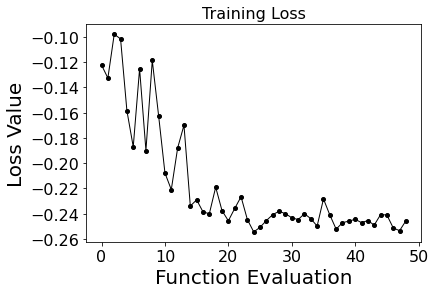

In [172]:
import scipy.optimize as sp

history=[] #history of losses through training

result = sp.minimize(f, [pi, pi, pi], method='COBYLA', constraints={'type': 'ineq', 'fun': lambda x: 2. * pi - x})

op=result.x #optimal parameters
print(f'Optimal parameters: {op}, Loss: {result.fun}')

fig = mpl.figure(figsize=(6, 4))
mpl.plot(history, 'ko-', markersize=4, linewidth=1)
mpl.title("Training Loss", fontsize=16)
mpl.xlabel("Function Evaluation",fontsize=20)
mpl.ylabel("Loss Value", fontsize=20)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.show()

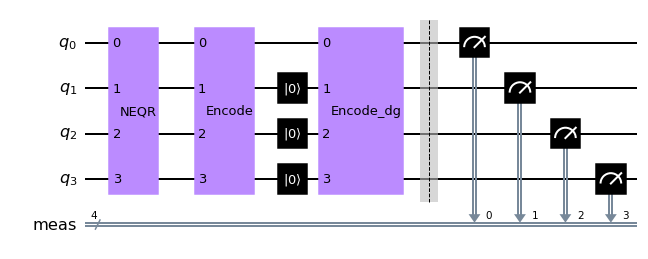

In [173]:
qc = QuantumCircuit(4)

qc.append(neqr(), qc.qubits[:4])

qc.append(encode(op), qc.qubits[:4])

qc.reset(1)
qc.reset(2)
qc.reset(3)

qc.append(encode(op).inverse(), qc.qubits[:4])

qc.measure_all()

qc.draw('mpl')

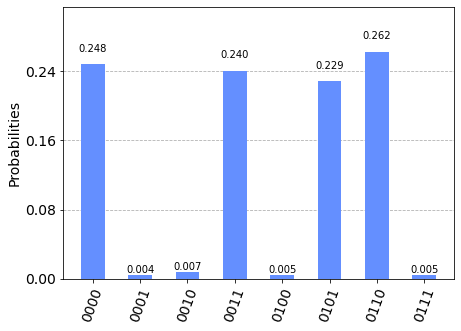

In [174]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc, shots=4096)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
plot_histogram(counts)

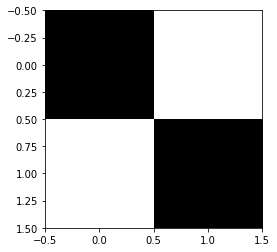

In [175]:
image=[[0, 0], [0, 0]]
values=[[0, 0], [0, 0]]
for x in counts:
    if x[-2:] == '00':
        if counts[x] > values[0][0]:
            values[0][0]=counts[x]
            image[0][0]=int(x[0:-2], 2)
    elif x[-2:] == '01':
        if counts[x] > values[0][1]:
            values[0][1]=counts[x]
            image[0][1]=int(x[0:-2], 2)
    elif x[-2:] == '10':
        if counts[x] > values[1][0]:
            values[1][0]=counts[x]
            image[1][0]=int(x[0:-2], 2)
    elif x[-2:] == '11':
        if counts[x] > values[1][1]:
            values[1][1]=counts[x]
            image[1][1]=int(x[0:-2], 2)
mpl.imshow(image, cmap="gray")